# Identify a MHW

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean

import matplotlib.pyplot as plt
import dask

In [2]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [3]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.a11eb2121c4042e7857d6dbe26d577d8/status,


In [4]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [17]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sst = ds_sst.sst

In [18]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<open_dataset-sst, shape=(50309, 109, 401), dtype=float32, chunksize=(45, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

# 90$^{th}$ percentile

In [21]:
q90 = sst.chunk().quantile(0.9, dim='time')

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [ ]:
q90

KeyboardInterrupt: 

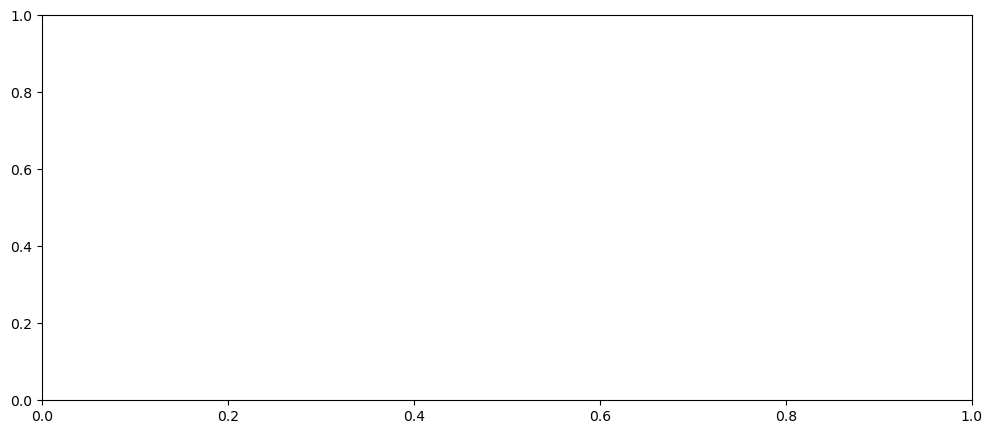

In [12]:
theta_levs = np.arange(28,34,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

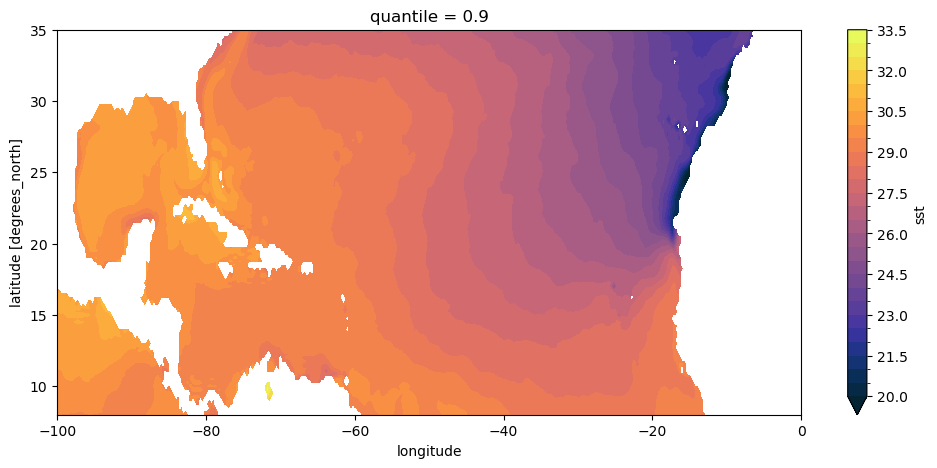

In [8]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

# Find temp above 90$^{th}$ percentile threshold

In [8]:
#daily clim
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    
    clim = sst.groupby('time.dayofyear').mean('time')
    clim_std = sst.groupby('time.dayofyear').std('time')
    anom = sst.groupby('time.dayofyear') - clim

#monthly clim
    mo_clim = sst.groupby('time.month').mean('time')
    mo_clim_std = sst.groupby('time.month').std('time')
    mo_anom = sst.groupby('time.month') - mo_clim

In [9]:
anom

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<sub, shape=(50309, 109, 401), dtype=float32, chunksize=(763, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    dayofyear  (time) int64 1 1 1 1 1 1 1 1 ... 270 270 270 271 271 271 271 271

In [10]:
mo_anom

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<sub, shape=(50309, 109, 401), dtype=float32, chunksize=(763, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 9 9 9 9 9 9 9 9 9 9 9 9

In [11]:
#above_thr = mo_anom.where(mo_anom>=q90, other=np.nan)#.chunk({'time':12577})
#above_thr = anom.where(anom>=q90, other=np.nan)
above_thr = clim.where(clim>=q90, other=np.nan)
above_thr_anom = (clim+anom).where((clim+anom)>=q90, other=np.nan)

In [12]:
above_thr

<xarray.DataArray 'sst' (dayofyear: 366, latitude: 109, longitude: 401)>
dask.array<where, shape=(366, 109, 401), dtype=float32, chunksize=(366, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    quantile   float64 0.9

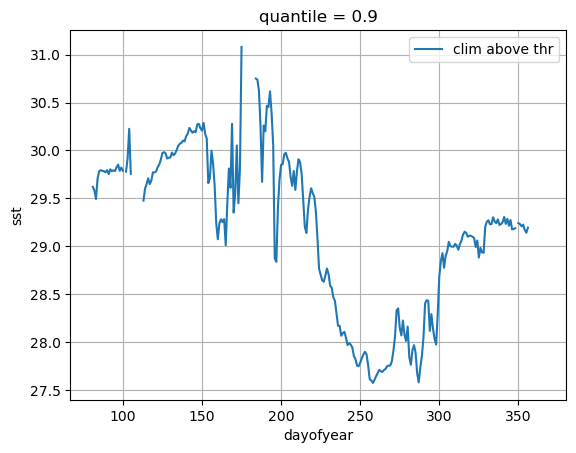

In [12]:
above_thr.mean(['latitude', 'longitude']).plot(label='clim above thr')
#above_thr_std.mean(['latitude', 'longitude']).plot(label='anom above thr')
plt.legend()
plt.grid();

In [ ]:
#above_thr.mean(['latitude', 'longitude']).plot(label='clim above thr')
above_thr_anom.mean(['latitude', 'longitude']).plot(label='anom above thr')
plt.legend()
plt.grid();

In [44]:
client.close()
cluster.close()